In [187]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

path = 'C:/Users/Zaca/Documents/Datasets/nyc/'

In [188]:
crime = pd.read_csv(path + 'nypd_historic_07-18.csv', index_col=0)

C:\Users\Zaca\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [189]:
crime = crime.groupby('date').agg(count=('precinct','count')).reset_index()
crime = crime.set_index('date')
crime.index = pd.to_datetime(crime.index)

# Monthly seasonality

In [190]:
weekly = crime.resample('W').mean()

In [191]:
weekly.drop(weekly.tail(1).index, inplace=True)

In [192]:
weekly.tail()

,count
date,
2018-12-02,1157.142857
2018-12-09,1118.714286
2018-12-16,1116.000000
2018-12-23,1092.000000
2018-12-30,961.000000


## Calculate stationarity
- Using ADFuller test

ADF Statistic: -5.166263622815082
p-value: 1.029896366427829e-05
Critical Values:
	1%: -3.441115625417986
	5%: -2.866289751785392
	10%: -2.56929951625907


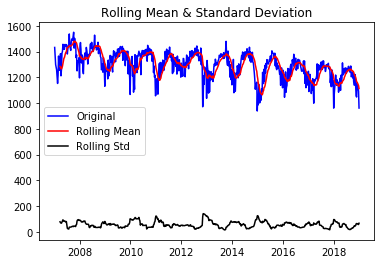

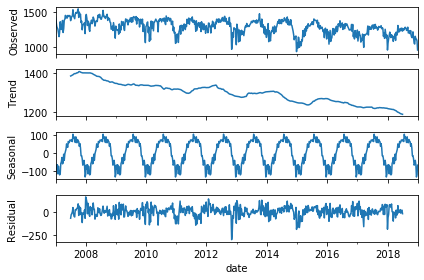

In [193]:
def get_stationarity(timeseries, window=12):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    
    decomposition = seasonal_decompose(timeseries)
    decomposition.plot();
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['count'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

get_stationarity(weekly)

- there is a strong seasonal component which is good!
- but there is also a trend :(

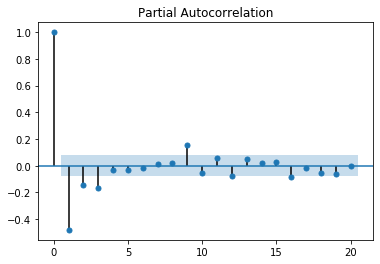

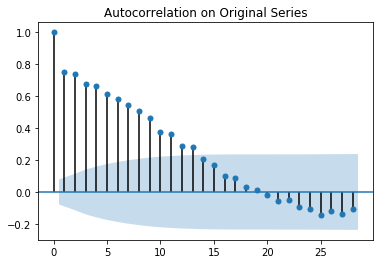

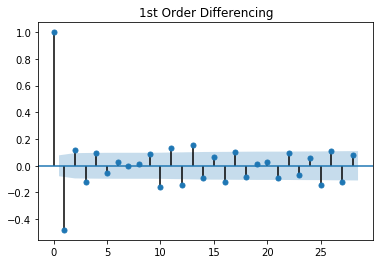

In [194]:
def auto_correlation(timeseries):

    fig = plot_pacf(timeseries.diff().dropna(), lags=20, title='Partial Autocorrelation')
    
    fig = plot_acf(timeseries, title="Autocorrelation on Original Series") 
    fig = plot_acf(timeseries.diff().dropna(), title="1st Order Differencing")
    
auto_correlation(weekly)

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.count   No. Observations:                  624
Model:                 ARIMA(4, 2, 2)   Log Likelihood               -3466.472
Method:                       css-mle   S.D. of innovations             62.157
Date:                Sat, 14 Mar 2020   AIC                           6948.943
Time:                        14:54:13   BIC                           6984.433
Sample:                    01-21-2007   HQIC                          6962.734
                         - 12-30-2018                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0027      0.007     -0.389      0.698      -0.016       0.011
ar.L1.D2.count    -1.5207      0.061    -24.866      0.000      -1.641      -1.401
ar.L2.D2.count    -0.7959      0.075    -10.544      0.000      -0.944      -0.648
ar.L3.D2.count    -0.4162      0.071     -5.838      0.000      -0.556      -0.276
ar.L4.D2.count    -0.1903      0.040     -4.781      0.000      -0.268      -0.112
ma.L1.D2.count    -0.0573      0.050     -1.153      0.249      -0.155       0.040
ma.L2.D2.count    -0.9425      0.050    -18.956      0.000      -1.040      -0.845
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1721           -0.0000j            1.1721           -0.5000
AR.2           -1.3202           -0.0000j            1.3202           -0.5000
AR.3            0.1527           -1.8364j            1.8428           -0.2368
AR.4            0.1527           +1.8364j            1.8428            0.2368
MA.1            1.0001           +0.0000j            1.0001            0.0000
MA.2           -1.0609           +0.0000j            1.0609            0.5000
-----------------------------------------------------------------------------
"""

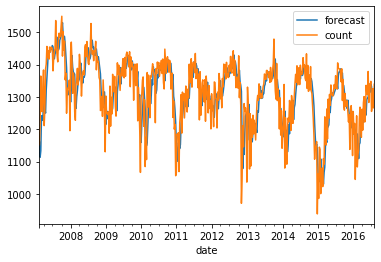

In [200]:
model = ARIMA(weekly, order=(4,2,2))
results = model.fit(disp=-1)

results.plot_predict(6,500);
results.summary()



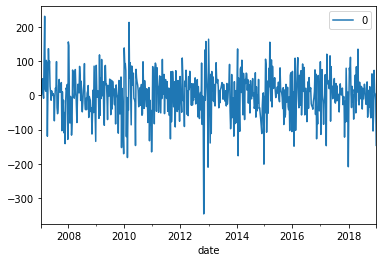

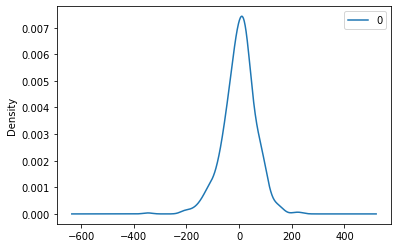

                0
count  624.000000
mean     1.294284
std     62.593806
min   -346.591399
25%    -33.016019
50%      6.548950
75%     38.573947
max    231.337542


In [196]:
residuals = pd.DataFrame(results.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [197]:
X = weekly.values
size = int(len(X) * 0.75)   # Split percentage

train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(4,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

C:\Users\Zaca\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Zaca\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


Test MSE: 42.265


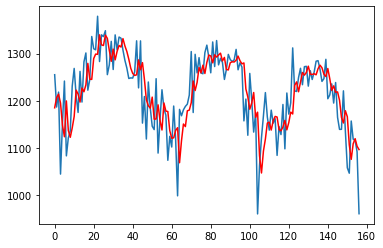

In [198]:
from sklearn.metrics import mean_absolute_error
error = mean_absolute_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
#plt.ylim(0, 160)
plt.show()

In [199]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(test, predictions)

3.5700398172644374